In [60]:
# 导入必要的库
import pandas as pd  # 用于数据处理
import numpy as np  # 用于数值计算
import json  # 用于处理JSON格式数据
# 绘图
import matplotlib.pyplot as plt  # 用于生成图表
from mplsoccer import VerticalPitch  # 专门用于足球比赛相关的图表绘制
# 统计模型拟合
import statsmodels.api as sm  # 提供广泛的统计模型
import statsmodels.formula.api as smf  # 通过公式形式拟合统计模型
# 打开数据文件
import os  # 用于操作系统相关的功能，如路径管理
import pathlib  # 用于更高层次的路径操作
import warnings  # 用于控制警告的显示

# 设置Pandas链式赋值模式为None，以忽略相关警告
pd.options.mode.chained_assignment = None
# 忽略警告信息
warnings.filterwarnings('ignore')

In [61]:
# 加载数据 - 存储到train数据框中
train = pd.DataFrame()  # 初始化一个空的数据框
# 准备空的数据框
path = os.path.join(str(pathlib.Path().resolve()), 'data', 'events','events_England.json')  # 拼接数据文件路径

# 打开JSON文件并读取数据
with open(path) as f:  # 打开指定路径的JSON文件
    data = json.load(f)  # 加载JSON数据到变量data中

# 将数据转换为Pandas DataFrame
train = pd.DataFrame(data)

# 查看数据框的基本信息，如列名、数据类型和内存占用
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


In [62]:
# 从train数据框中筛选出所有射门事件
shots = train.loc[train['subEventName'] == 'Shot']

# 获取射门位置坐标并分别存储在X和Y列中
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)  # 计算射门的X坐标并转换为球场尺度（105米）
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)  # 计算射门的Y坐标并转换为球场尺度（68米）
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)  # 计算射门与球场中线（Y=50）之间的垂直距离

# 计算射门距离和角度
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)  # 使用勾股定理计算射门距离
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0,
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)),
                          np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
# 计算射门角度（使用球门的宽度7.32米）

# 如果在建模过程中遇到依赖变量0和1颠倒的问题，可以将目标变量转换为object类型
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)  # 标记是否进球，'id':101表示进球事件

In [64]:
shot_feature = ['Angle','Distance','X','C','Y','Goal']
shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8451 entries, 46 to 643149
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eventId       8451 non-null   int64  
 1   subEventName  8451 non-null   object 
 2   tags          8451 non-null   object 
 3   playerId      8451 non-null   int64  
 4   positions     8451 non-null   object 
 5   matchId       8451 non-null   int64  
 6   eventName     8451 non-null   object 
 7   teamId        8451 non-null   int64  
 8   matchPeriod   8451 non-null   object 
 9   eventSec      8451 non-null   float64
 10  subEventId    8451 non-null   object 
 11  id            8451 non-null   int64  
 12  X             8451 non-null   float64
 13  Y             8451 non-null   float64
 14  C             8451 non-null   float64
 15  Distance      8451 non-null   float64
 16  Angle         8451 non-null   float64
 17  Goal          8451 non-null   object 
dtypes: float64(6), int64(5), objec

In [67]:
shots_data  = shots[shot_feature]
shots_data

,Angle,Distance,X,C,Y,Goal
46,0.467241,14.007655,12.60,6.12,27.88,1
62,0.453557,15.808608,15.75,1.36,35.36,0
91,1.375115,4.414703,4.20,1.36,35.36,1
128,0.274666,23.057235,19.95,11.56,22.44,0
249,0.219665,29.563872,26.25,13.60,20.40,0
...,...,...,...,...,...,...
642945,0.244517,29.595946,29.40,3.40,30.60,0
643023,0.309646,18.700898,14.70,11.56,22.44,1
643051,0.410444,15.011516,12.60,8.16,42.16,0
643055,0.461143,11.710918,8.40,8.16,25.84,0


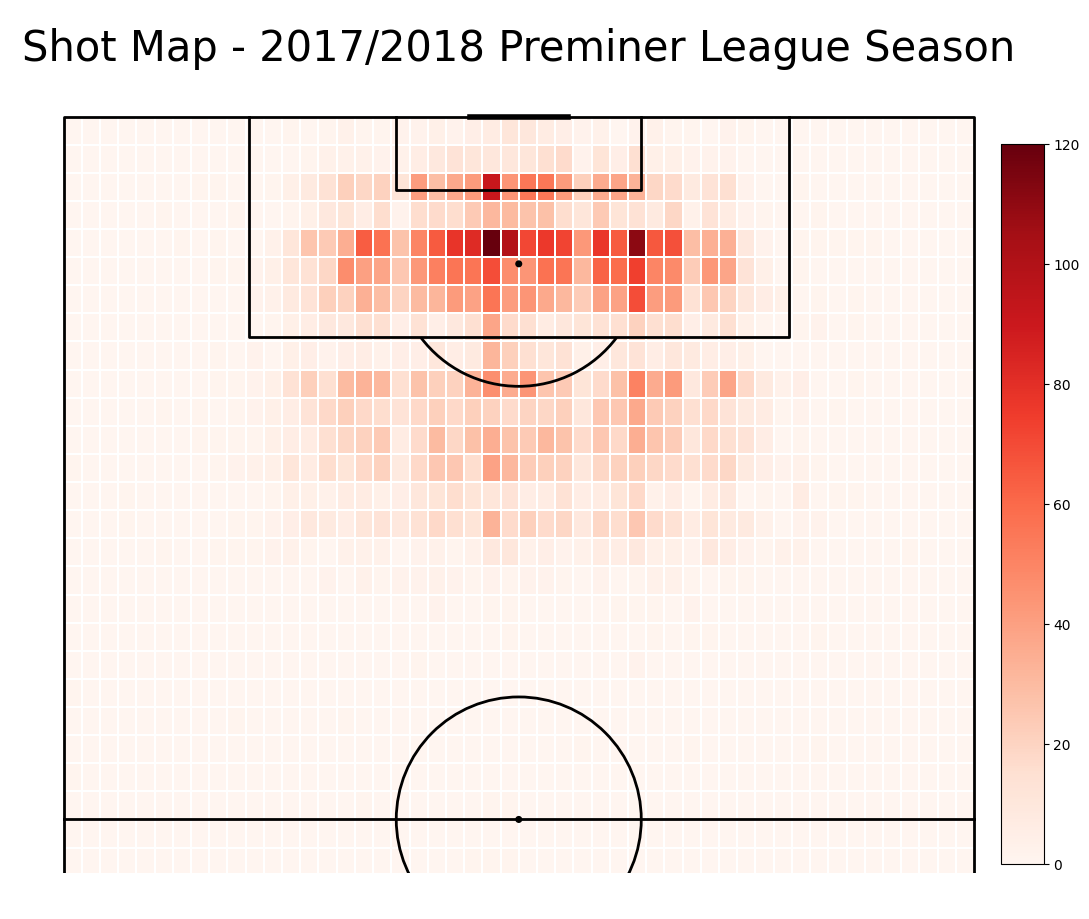

In [32]:
# 绘制球场图
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# 从105中减去X坐标，但不从68中减去Y坐标，因为Wyscout坐标系是反向的

# 计算每个网格单元中的射门数量
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# 绘制热力图
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth=0.01)

# 添加图例
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))  # 定义图例的颜色条区域
cbar = plt.colorbar(pcm, cax=ax_cbar)

# 设置图表标题
fig.suptitle('Shot Map - 2017/2018 Preminer League Season', fontsize=30)

# 显示图表
plt.show()


In [33]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8451 entries, 46 to 643149
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eventId       8451 non-null   int64  
 1   subEventName  8451 non-null   object 
 2   tags          8451 non-null   object 
 3   playerId      8451 non-null   int64  
 4   positions     8451 non-null   object 
 5   matchId       8451 non-null   int64  
 6   eventName     8451 non-null   object 
 7   teamId        8451 non-null   int64  
 8   matchPeriod   8451 non-null   object 
 9   eventSec      8451 non-null   float64
 10  subEventId    8451 non-null   object 
 11  id            8451 non-null   int64  
 12  X             8451 non-null   float64
 13  Y             8451 non-null   float64
 14  C             8451 non-null   float64
 15  Distance      8451 non-null   float64
 16  Angle         8451 non-null   float64
 17  Goal          8451 non-null   object 
dtypes: float64(6), int64(5), objec

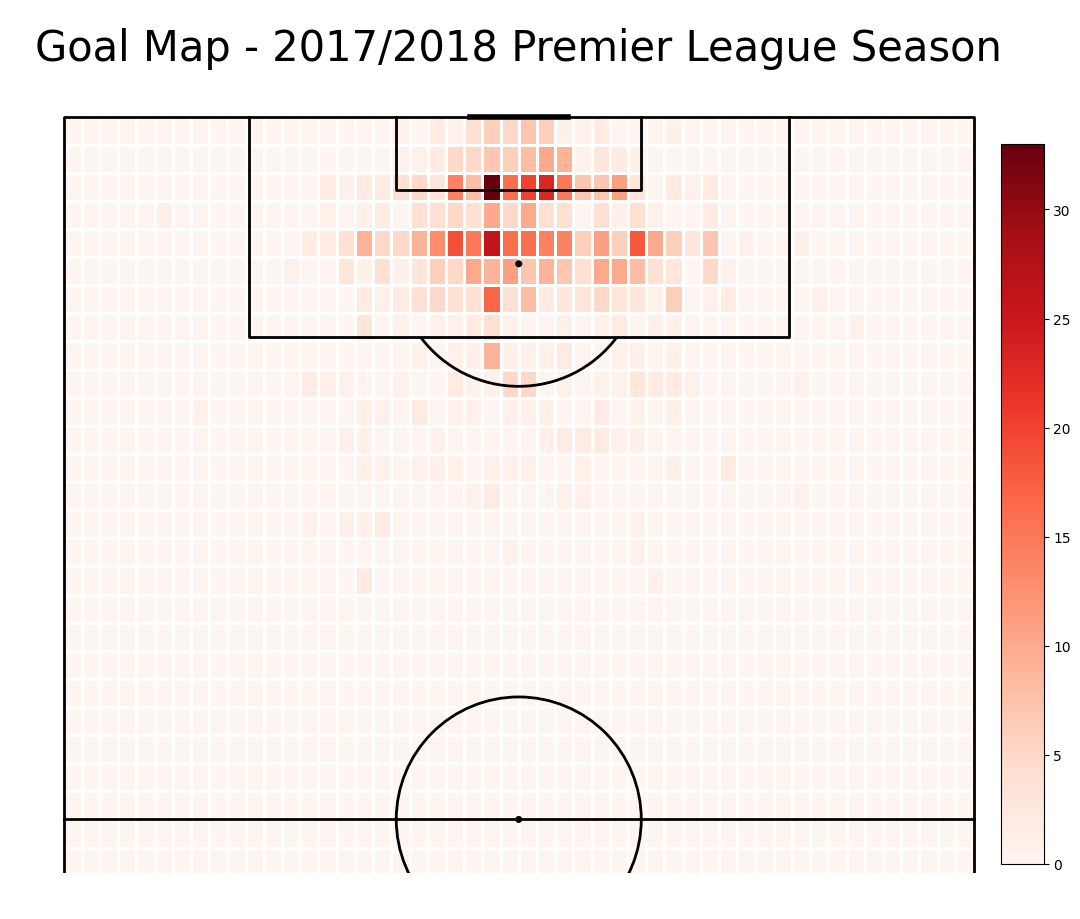

In [34]:
# 筛选出所有进球事件
goals = shots.loc[shots["Goal"] == 1]

# 绘制球场图
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# 计算每个网格单元中的进球数量
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

# 绘制进球热力图
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

# 添加图例
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))  # 定义图例的颜色条区域
cbar = plt.colorbar(pcm, cax=ax_cbar)

# 设置图表标题
fig.suptitle('Goal Map - 2017/2018 Premier League Season', fontsize=30)

# 显示图表
plt.show()


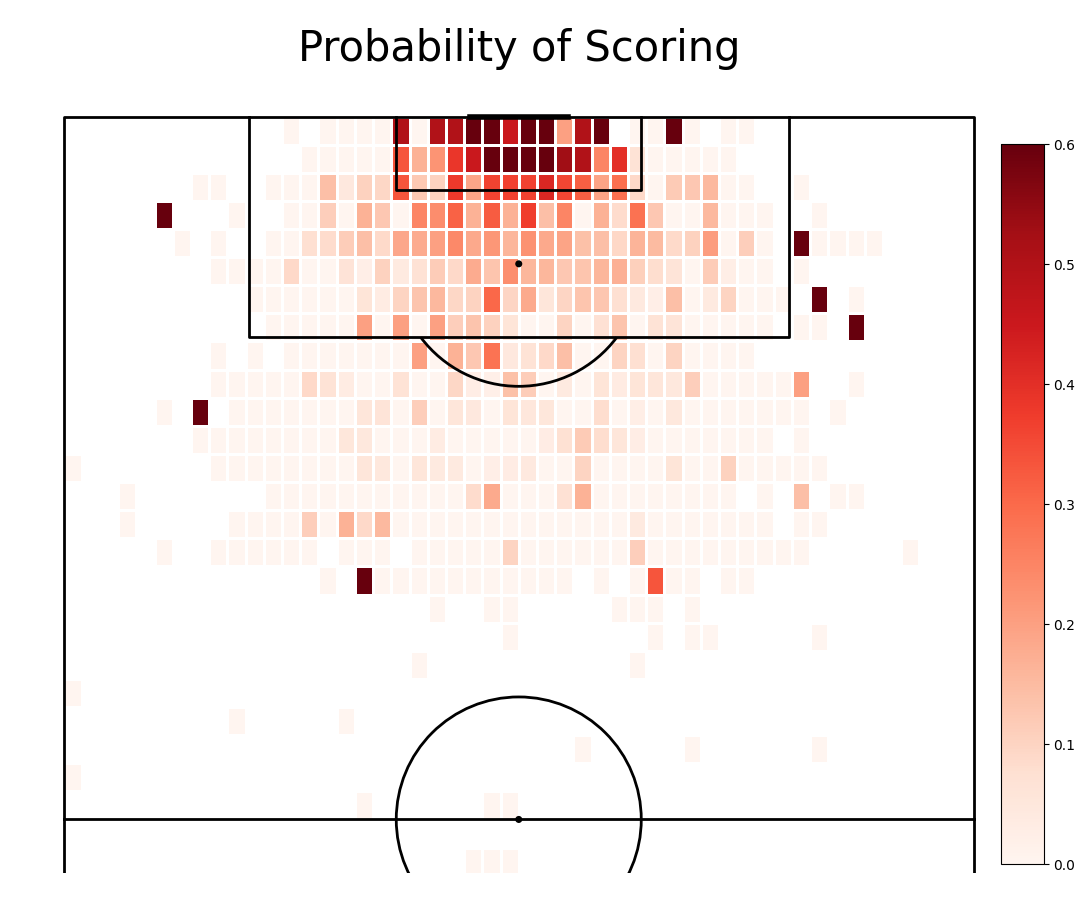

In [35]:
# 绘制球场图
pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# 计算每个网格单元中的射门数量
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# 正规化进球数（用进球数除以射门数）
bin_statistic["statistic"] = bin_statistic_goals["statistic"] / bin_statistic["statistic"]

# 绘制热力图，显示得分概率
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin=0, vmax=0.6)

# 添加图例
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))  # 定义图例颜色条的位置
cbar = plt.colorbar(pcm, cax=ax_cbar)

# 设置图表标题
fig.suptitle('Probability of Scoring', fontsize=30)

# 显示图表
plt.show()


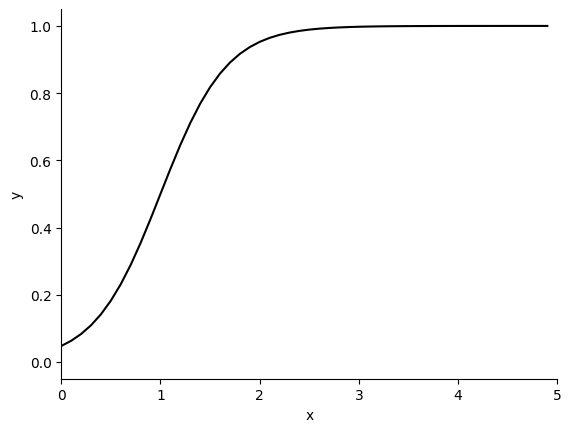

In [36]:
# 定义参数b
b = [3, -3]

# 创建x的范围，从0到5，以0.1为步长
x = np.arange(5, step=0.1)

# 计算逻辑函数值y，使用1/(1+exp(b0 + b1*x))公式
y = 1/(1 + np.exp(b[0] + b[1]*x))

# 创建图表和轴
fig, ax = plt.subplots()

# 设置y轴的显示范围
plt.ylim((-0.05, 1.05))

# 设置x轴的显示范围
plt.xlim((0, 5))

# 设置y轴的标签
ax.set_ylabel('y')

# 设置x轴的标签
ax.set_xlabel("x")

# 绘制x与y的折线图，使用实线并设置为黑色
ax.plot(x, y, linestyle='solid', color='black')

# 隐藏图表顶部的边框线
ax.spines['top'].set_visible(False)

# 隐藏图表右侧的边框线
ax.spines['right'].set_visible(False)

# 显示图表
plt.show()


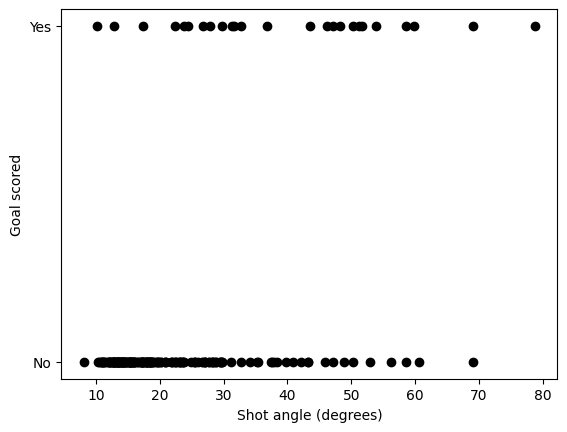

In [37]:
#first 200 shots
shots_200=shots.iloc[:200]
#plot first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()
# # 取前200个射门事件
# shots_200 = shots.iloc[:200]

# # 绘制前200个射门的角度和是否进球的图
# fig, ax = plt.subplots()

# # 绘制散点图，x轴为射门角度（弧度转为角度），y轴为是否进球
# ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker='.', markersize=12, color='black')

# # 设置图例标签
# ax.set_ylabel('是否进球')  # y轴标签为"是否进球"
# ax.set_xlabel("射门角度（度数）")  # x轴标签为"射门角度（度数）"

# # 设置y轴显示范围
# plt.ylim((-0.05, 1.05))

# # 设置y轴刻度为0和1，分别代表未进球和进球
# ax.set_yticks([0, 1])
# ax.set_yticklabels(['未进球', '进球'])  # 将刻度标签设为“未进球”和“进球”

# # 显示图表
# plt.show()


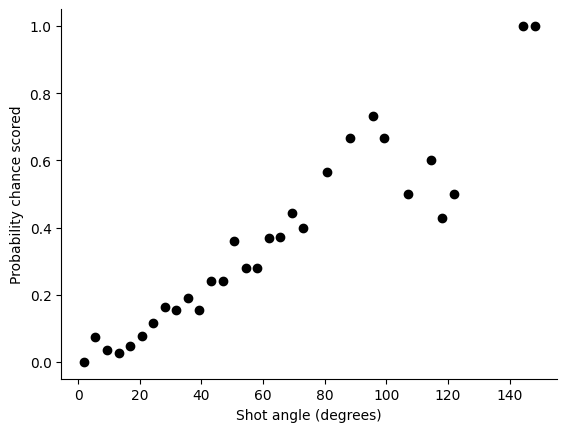

In [38]:
#number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])
#number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')
#probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2
#make plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

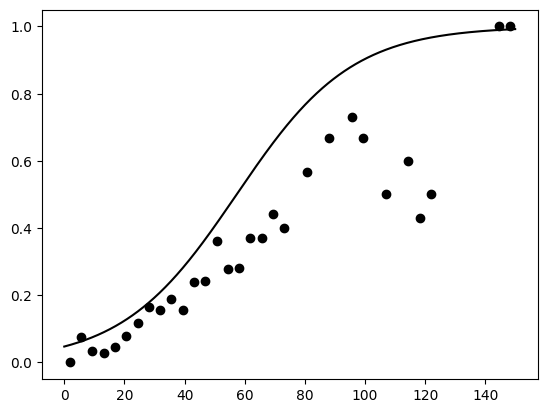

In [39]:
fig, ax = plt.subplots()
b = [3, -3]
x = np.arange(150,step=0.1)
y = 1/(1+np.exp(b[0]+b[1]*x*np.pi/180))
#plot line
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

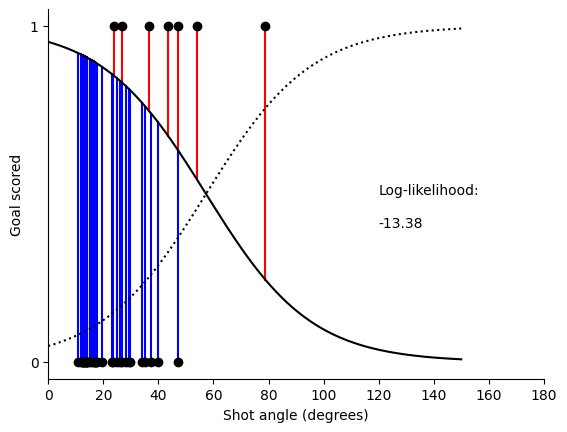

In [40]:
#calculate xG
xG = 1/(1+np.exp(b[0]+b[1]*shots['Angle']))
shots = shots.assign(xG = xG)
shots_40 = shots.iloc[:40]
fig, ax = plt.subplots()
#plot data
ax.plot(shots_40['Angle']*180/np.pi, shots_40['Goal'], linestyle='none', marker= '.', markersize= 12, color='black', zorder = 3)
#plot curves
ax.plot(x, y, linestyle=':', color='black', zorder = 2)
ax.plot(x, 1-y, linestyle='solid', color='black', zorder = 2)
#calculate loglikelihood
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang = shot['Angle'] * 180/np.pi
    if shot['Goal'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG'])
        ax.plot([ang,ang],[shot['Goal'],1-shot['xG']], color='red', zorder = 1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG'])
        ax.plot([ang,ang], [shot['Goal'], 1-shot['xG']], color='blue', zorder = 1)
#make legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,180))
plt.text(120,0.5,'Log-likelihood:')
plt.text(120,0.4,str(loglikelihood)[:6])
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2561.2
Date:                    Fri, 04 Oct 2024   Deviance:                       5122.5
Time:                            20:35:03   Pearson chi2:                 7.96e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

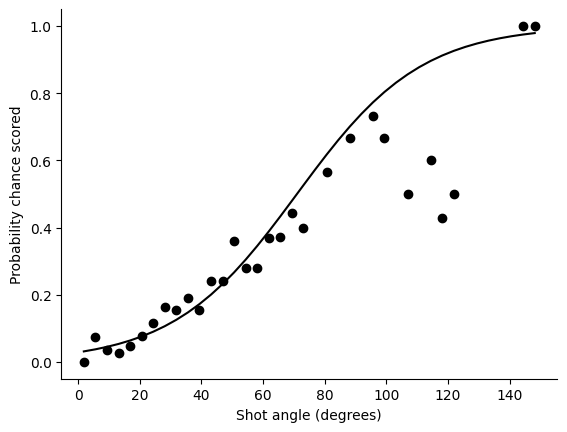

In [41]:
#create model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots,
                           family=sm.families.Binomial()).fit()
print(test_model.summary())
#get params
b=test_model.params
#calculate xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))
fig, ax = plt.subplots()
#plot data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
#plot line
ax.plot(midangle, xGprob, linestyle='solid', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8449
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2524.4
Date:                    Fri, 04 Oct 2024   Deviance:                       5048.9
Time:                            20:35:03   Pearson chi2:                 1.56e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.08410
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

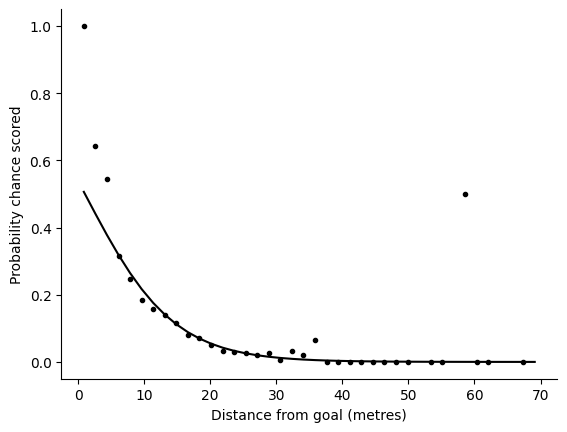

In [42]:
#number of shots
shotcount_dist = np.histogram(shots['Distance'],bins=40,range=[0, 70])
#number of goals
goalcount_dist = np.histogram(goals['Distance'],bins=40,range=[0, 70])
#empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
#making a plot
fig, ax = plt.subplots()
#plotting data
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#make single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance))
#plot line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8448
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2505.6
Date:                    Fri, 04 Oct 2024   Deviance:                       5011.1
Time:                            20:35:03   Pearson chi2:                 8.44e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08818
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

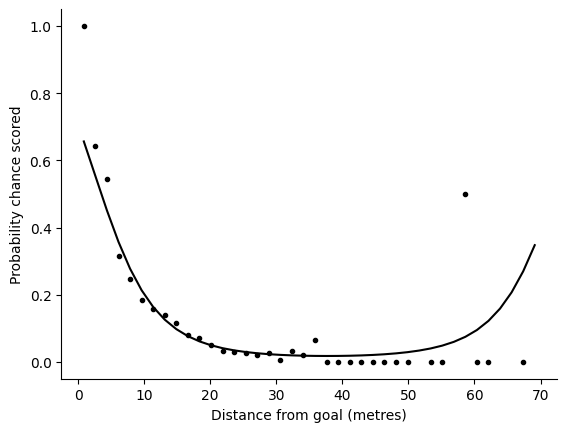

In [43]:
#calculating distance squared
shots["D2"] = shots['Distance']**2
#adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots,
                           family=sm.families.Binomial()).fit()
#print model summary
print(test_model.summary())
#get parameters
b=test_model.params
#calculate xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))
fig, ax = plt.subplots()
#plot line
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
#make legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()


                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8451
Model:                                GLM   Df Residuals:                     8443
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2498.7
Date:                    Fri, 04 Oct 2024   Deviance:                       4997.4
Time:                            20:35:04   Pearson chi2:                 8.40e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.08966
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

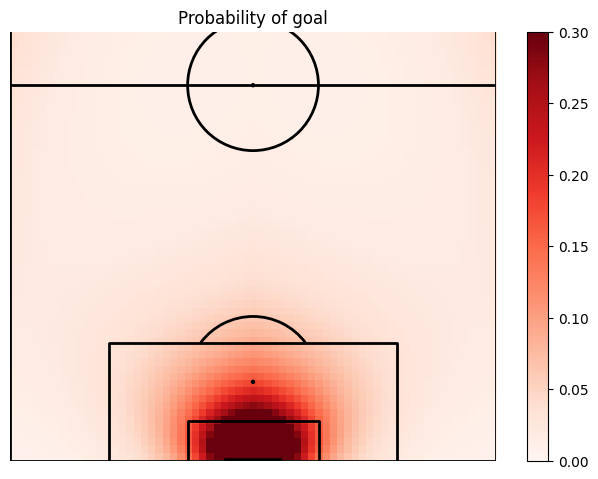

In [44]:
#creating extra variables
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

#fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots,
                           family=sm.families.Binomial()).fit()
#print summary
print(test_model.summary())
b=test_model.params

#return xG value for more general model
def calculate_xG(sh):
   bsum=b[0]
   for i,v in enumerate(model_variables):
       bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

#add an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1)
shots = shots.assign(xG=xG)

#Create a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()
#plot probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)
#make legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Mcfaddens Rsquared 0.13708006325049082


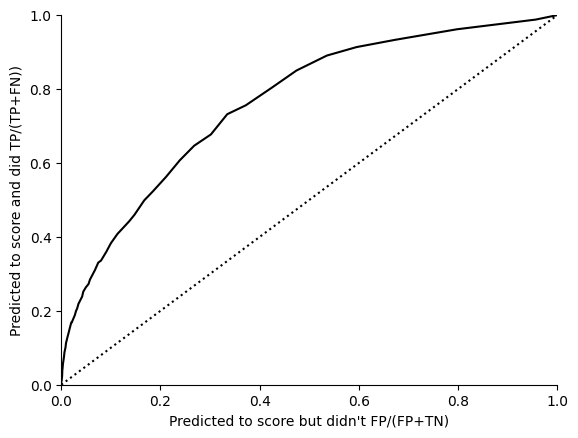

In [45]:
# Mcfaddens Rsquared for Logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots,
                     family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

        Angle   Distance        xG
46   0.467241  14.007655  0.144127
62   0.453557  15.808608  0.000000
91   1.375115   4.414703  0.643467
128  0.274666  23.057235  0.000000
249  0.219665  29.563872  0.000000


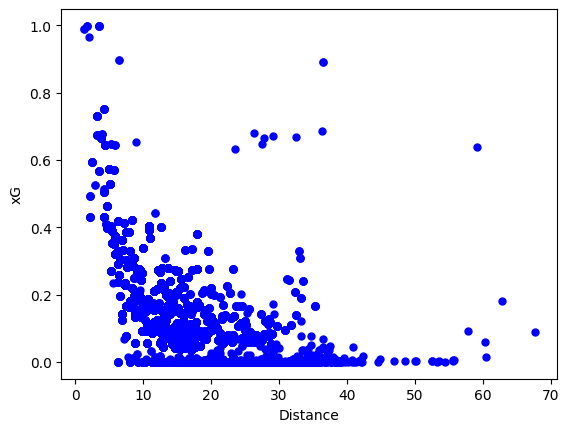

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 准备数据
features = shots[model_variables]
target = shots['Goal'].astype(int)  # 确保目标变量为整数

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# 训练模型
rf_model.fit(features, target)

# 使用训练好的模型计算每次射门的xG值
shots['xG'] = rf_model.predict(features)

# 查看添加了xG值的DataFrame
print(shots[['Angle', 'Distance', 'xG']].head())

# 可视化xG值
fig, ax = plt.subplots()
ax.plot(shots['Distance'], shots['xG'], linestyle='none', marker='.', markersize=10, color='blue')
ax.set_xlabel('Distance')
ax.set_ylabel('xG')
plt.show()


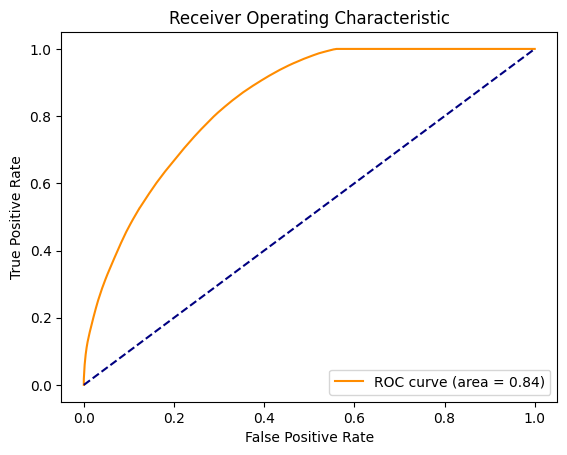

In [58]:
from sklearn.metrics import roc_curve, auc

# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(target, shots['xG'])
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.show()


In [55]:
target.info

<bound method Series.info of 46        1
62        0
91        1
128       0
249       0
         ..
642945    0
643023    1
643051    0
643055    0
643149    0
Name: Goal, Length: 8451, dtype: int64>

In [56]:
features.info

<bound method DataFrame.info of            Angle   Distance      X      C        X2        C2        AX
46      0.467241  14.007655  12.60   6.12  158.7600   37.4544  5.887234
62      0.453557  15.808608  15.75   1.36  248.0625    1.8496  7.143529
91      1.375115   4.414703   4.20   1.36   17.6400    1.8496  5.775484
128     0.274666  23.057235  19.95  11.56  398.0025  133.6336  5.479587
249     0.219665  29.563872  26.25  13.60  689.0625  184.9600  5.766201
...          ...        ...    ...    ...       ...       ...       ...
642945  0.244517  29.595946  29.40   3.40  864.3600   11.5600  7.188798
643023  0.309646  18.700898  14.70  11.56  216.0900  133.6336  4.551802
643051  0.410444  15.011516  12.60   8.16  158.7600   66.5856  5.171595
643055  0.461143  11.710918   8.40   8.16   70.5600   66.5856  3.873598
643149  0.488036  14.700000  14.70   0.00  216.0900    0.0000  7.174131

[8451 rows x 7 columns]>